In [90]:
import torch 
from torch.utils.data import DataLoader
from fn_utils import HAM10kCustom
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from ResNet import res_net_101
import os
from torchmetrics import Accuracy, ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
df = pd.read_csv("data/skin_cancer_df.csv")
X, y = df["image_path"], df["dx_expanded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

test_transforms = v2.Compose([
    v2.Resize(size=(96, 96)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = HAM10kCustom(X_test, y_test, test_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [92]:
net_101 = res_net_101(num_classes=7, block_input_layout=(32, 64, 128, 256))
net_101_path = os.path.join(os.getcwd(), "models", "net_101_v5.pth")
net101_state_dict = torch.load(net_101_path, weights_only=False)
net_101.load_state_dict(net101_state_dict)
net_101 = net_101.to("cuda")

In [93]:
class_names = test_data.classes

In [94]:
accuracy_fn_t3 = Accuracy(task="multiclass", num_classes=7, top_k=3).to("cuda")
accuracy_fn_t1 = Accuracy(task="multiclass", num_classes=7).to("cuda")
conf_matrix_fn = ConfusionMatrix(num_classes=7, task="multiclass").to("cuda")
net_101.eval()
all_preds = []
all_labels = []
with torch.inference_mode():
    total_t3_acc = 0
    total_t1_acc = 0
    for batch, (X, y) in enumerate(test_loader):
        X, y = X.to("cuda"), y.to("cuda")
        outputs = net_101(X)
        top3_acc = accuracy_fn_t3(outputs, y)
        top1_acc = accuracy_fn_t1(outputs, y)
        total_t3_acc += top3_acc
        total_t1_acc += top1_acc
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        conf_matrix_fn.update(preds, y)
    
    confusion_matrix = conf_matrix_fn.compute().cpu().numpy()  
    total_t3_acc /= len(test_loader)
    total_t1_acc /= len(test_loader)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)

print(f"Test Accuracy@3: {total_t3_acc*100:.2f}%")
print(f"Test Accuracy@1: {total_t1_acc*100:.2f}%")

Test Accuracy@3: 96.09%
Test Accuracy@1: 76.12%


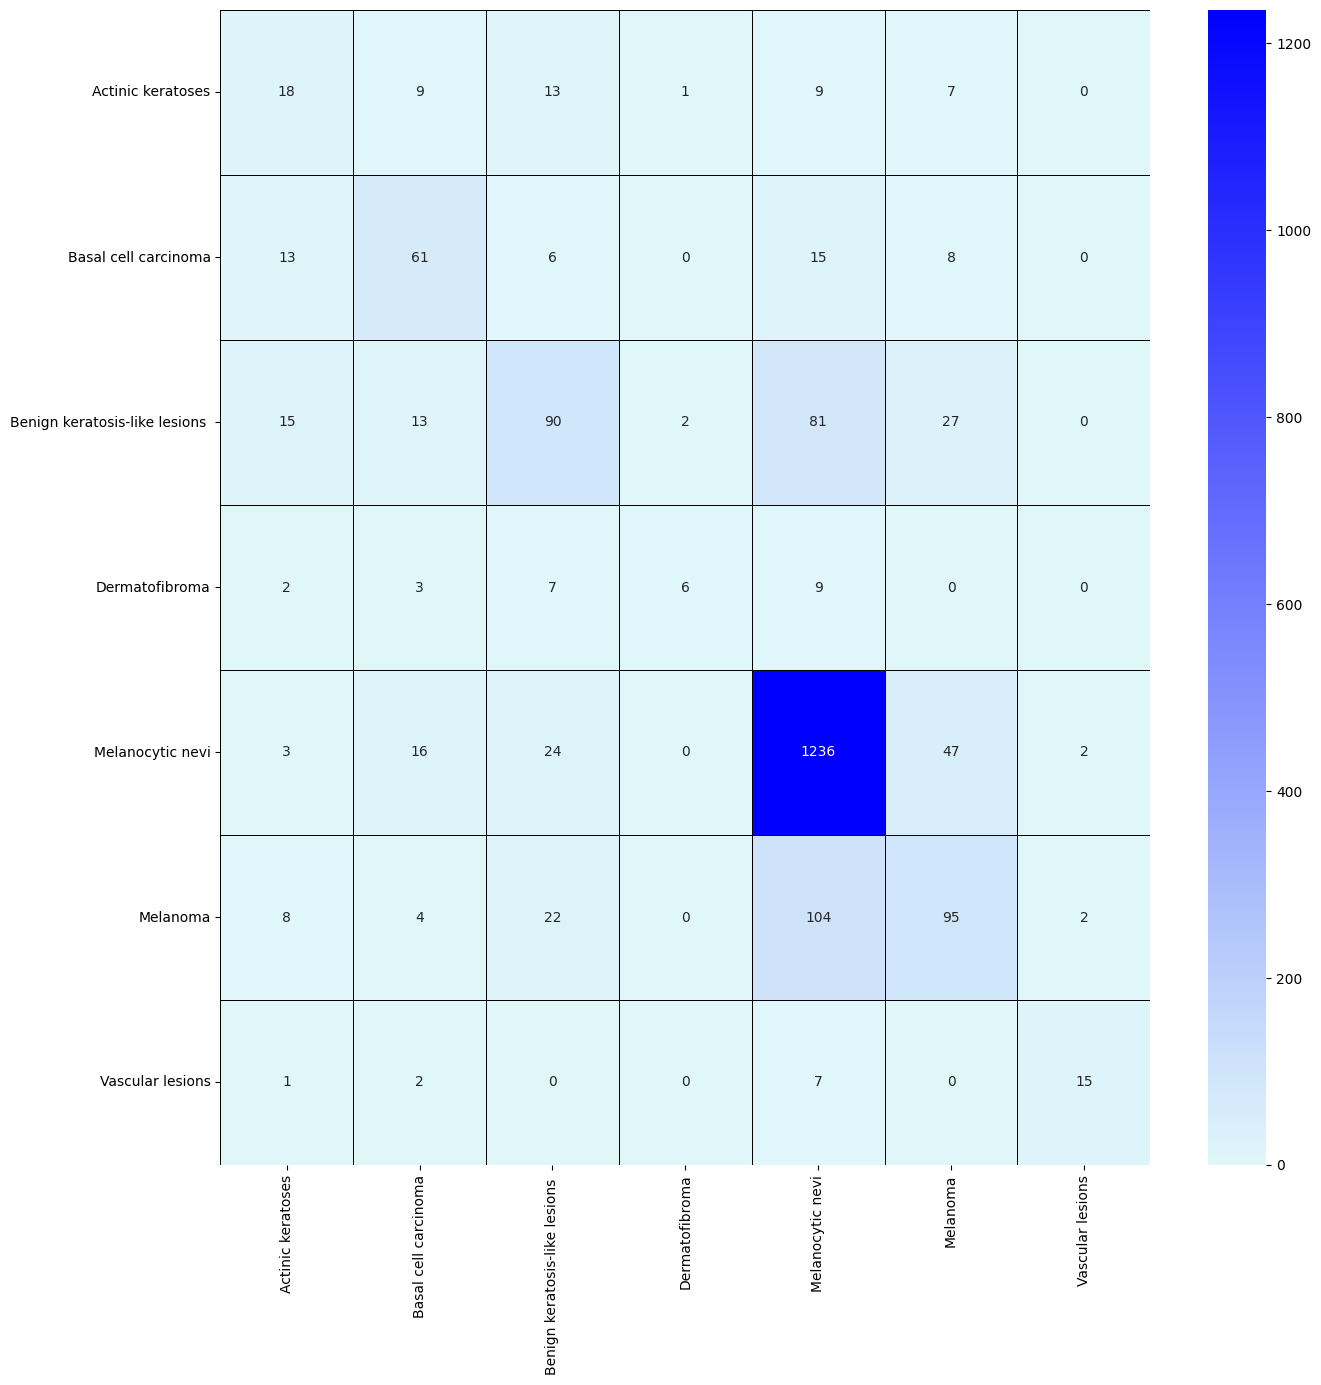

In [95]:
plt.figure(figsize=(15,15))
pal = sns.blend_palette(["#e0f7fa", "blue"], as_cmap=True)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=pal, 
            xticklabels=class_names,
            yticklabels=class_names,
            linewidths=0.5, 
            linecolor='black')
plt.savefig("plots/Confusion_matrix.jpg")
plt.show()